In [ ]:
import pandas as pd
from datetime import date
import seaborn as sns
import numpy as np
import wordcloud as wc
import matplotlib as mat
from matplotlib import pyplot as plt
from pandas.api.types import CategoricalDtype
import sklearn as sk
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

**Analysis on Calendar.csv**

In [ ]:
calendar_raw_df = pd.read_csv(r'calendar.csv', parse_dates=['date'])
print(calendar_raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1393570 non-null  int64         
 1   date        1393570 non-null  datetime64[ns]
 2   available   1393570 non-null  object        
 3   price       934542 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 42.5+ MB
None


In [ ]:
calendar_raw_df['price'].replace('\$|,', '', regex=True, inplace=True)
calendar_raw_df['price'].fillna(0, inplace=True)
calendar_raw_df['price'] = calendar_raw_df['price'].astype('float')

calendar_raw_df['year'] = calendar_raw_df['date'].dt.year
calendar_raw_df['month'] = calendar_raw_df['date'].dt.month
calendar_raw_df['day'] = calendar_raw_df['date'].dt.day
calendar_raw_df['day_name'] = calendar_raw_df['date'].dt.day_name()

calendar_raw_df['available'].replace({'t|T': 1, 'f|F': 0}, regex=True, inplace=True)

(0.0, 400.0)

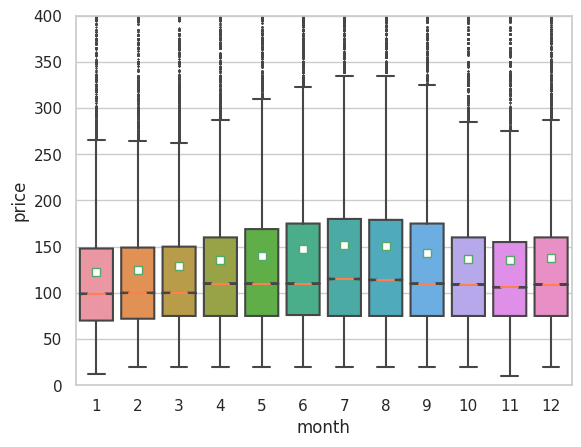

In [ ]:
avail_listing_cond = calendar_raw_df['available'] == 1  # select all available listing
avail_listing_df = calendar_raw_df.loc[avail_listing_cond, :]

# 2_1 Question 1: demonstrate the price distribution of each month, including the
# average price, max/min price, and other metrics.
sns.set_theme(style="whitegrid")

ax2_1 = sns.boxplot(data=avail_listing_df, x='month', y='price', fliersize=1, showmeans=True,
                    flierprops={"marker": "x"}, medianprops={"color": "coral"}, notch=True,
                    meanprops={"marker": "s", "markerfacecolor": "white"})
ax2_1.set_xticklabels(ax2_1.get_xticklabels())
ax2_1.set_ylim(0, 400)

Text(0.5, 1.0, 'Distribution of listing from January to December')

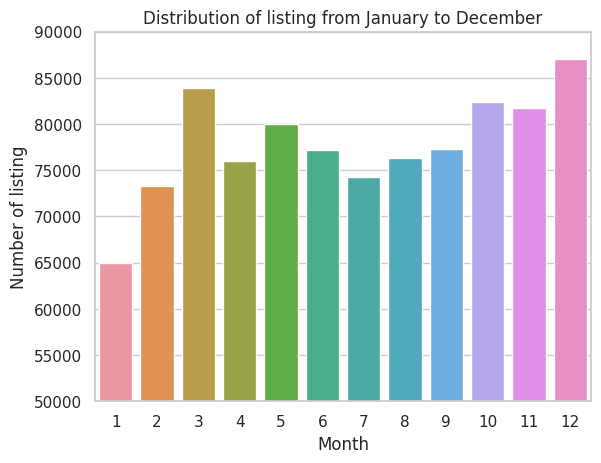

In [ ]:
list_mon_grouped = avail_listing_df.groupby('month').count()
ax2_2 = sns.barplot(x=list_mon_grouped.index.values, y=list_mon_grouped['listing_id'].values)
ax2_2.set_ylim(50000, 90000)
ax2_2.set_ylabel("Number of listing")
ax2_2.set_xlabel("Month")
ax2_2.set_title("Distribution of listing from January to December")

<ipython-input-7-8551681b3888>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  list_wd_avg_grouped = avail_listing_df.groupby('day_name', as_index=False).mean()


(135.0, 145.0)

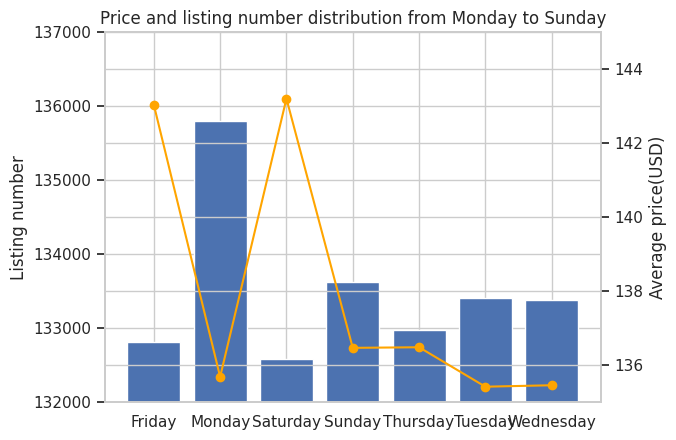

In [ ]:
day_name_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# avail_listing_df.loc[:, 'day_name'] = avail_listing_df.loc[:, 'day_name'].astype(CategoricalDtype(day_name_list))
avail_listing_df.loc[:, 'day_name'].astype(CategoricalDtype(day_name_list), copy=False)
list_wd_avg_grouped = avail_listing_df.groupby('day_name', as_index=False).mean()
list_wd_count_grouped = avail_listing_df.groupby('day_name', as_index=False).count()
list_wd_avg_grouped.sort_values('day_name')
list_wd_count_grouped.sort_values('day_name')

fig, ax2_3_a = plt.subplots()
ax2_3_a.bar(x=list_wd_avg_grouped['day_name'], height=list_wd_count_grouped['price'].values)
ax2_3_a.set_ylim(132000, 137000)
ax2_3_a.set_ylabel("Listing number")
ax2_3_a.set_title("Price and listing number distribution from Monday to Sunday")
ax2_3_b = ax2_3_a.twinx()
ax2_3_b.plot(list_wd_avg_grouped['price'].values, color='orange', marker='o')
ax2_3_b.set_ylabel("Average price(USD)")
ax2_3_b.set_xlabel("Day name")
ax2_3_b.set_ylim(135, 145)

**Analysis on Listing.csv**

In [ ]:
listing_raw_df = pd.read_csv(r'listings.csv',
                             parse_dates=['host_since', 'last_scraped', 'first_review', 'last_review'])
print(listing_raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3818 non-null   int64         
 1   listing_url                       3818 non-null   object        
 2   scrape_id                         3818 non-null   int64         
 3   last_scraped                      3818 non-null   datetime64[ns]
 4   name                              3818 non-null   object        
 5   summary                           3641 non-null   object        
 6   space                             3249 non-null   object        
 7   description                       3818 non-null   object        
 8   experiences_offered               3818 non-null   object        
 9   neighborhood_overview             2786 non-null   object        
 10  notes                             2212 non-null 

In [ ]:
pd.set_option('display.max_columns', None)
print("There are {} entries in this dataset".format(listing_raw_df.shape[0]))
# print(listing_raw_df.head(10))

# 1_2: Drop any columns contains URL because these columns are irrelevant to the room properties
url_list = ['listing_url', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url','host_thumbnail_url',
            'host_picture_url']
listing_df = listing_raw_df.drop(url_list, axis=1)

# 1_3: Drop entries missing price data since entries missing price data will lose their analytical value
listing_df.dropna(subset=['price'], inplace=True)

numeric_column = ['price', 'weekly_price', 'monthly_price', 'cleaning_fee', 'extra_people',
                  'security_deposit', 'host_response_rate', 'host_acceptance_rate']
for numeric_col in numeric_column:
    listing_df[numeric_col].replace('\$|,|%', '', regex=True, inplace=True)
    listing_df[numeric_col] = pd.to_numeric(listing_df[numeric_col], errors="coerce", downcast='float').fillna(0)
#     listing_df[numeric_col].astype('float64', copy=False, errors="ignore")
print(listing_df.info())
# 1_4_b: covert `host_since`, `last_scraped`, `first_review`, `last_review` to float days
today = date.today()
date_related_col = ['host_since', 'last_scraped', 'first_review', 'last_review']
for date_col in date_related_col:
    listing_df[date_col] = pd.to_datetime(today) - listing_df[date_col]

rate_column = ['host_response_rate', 'host_acceptance_rate']
for rate_col in rate_column:
    listing_df[rate_col] = listing_df[rate_col].apply(lambda x: round(x / 100, 2))

# 1_4_d: Fill NaN cells with 0 on those numeric columns
num_listing_df = listing_df.select_dtypes(include=[int, np.float32, np.float64])
num_listing_df.fillna(0, inplace=True)
print(num_listing_df.info())

# 1_4_e: Fill NaN cells with "None" on those string columns
str_listing_df = listing_df.select_dtypes(include=['object'])
str_listing_df.fillna('None', inplace=True)

# 1_4_f: Fill 1 or 0 for the boolean value
boolean_column = ['host_has_profile_pic', 'host_is_superhost', 'host_identity_verified', 'has_availability',
                  'requires_license', 'instant_bookable', 'require_guest_profile_picture',
                  'require_guest_phone_verification']

for boolean_col in boolean_column:
    listing_df[boolean_col].replace({'t|T': 1, 'f|F': 0}, regex=True, inplace=True)

print("General data cleanning process finished!")

There are 3818 entries in this dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 84 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3818 non-null   int64         
 1   scrape_id                         3818 non-null   int64         
 2   last_scraped                      3818 non-null   datetime64[ns]
 3   name                              3818 non-null   object        
 4   summary                           3641 non-null   object        
 5   space                             3249 non-null   object        
 6   description                       3818 non-null   object        
 7   experiences_offered               3818 non-null   object        
 8   neighborhood_overview             2786 non-null   object        
 9   notes                             2212 non-null   object        
 10  transit  

In [ ]:
listing_df['amenities'].replace(r'[\{\}\"\']', '', regex=True, inplace=True)
listing_df['host_verifications'].replace(r'[\[\]\"\'\s]', '', regex=True, inplace=True)

# 2_1_b: Create dummies for the `amenities` column
ame_split_df = listing_df['amenities'].str.split(',')
mlb = MultiLabelBinarizer()
ame_dummy = pd.DataFrame(mlb.fit_transform(ame_split_df), columns=mlb.classes_, index=ame_split_df.index)
ame_dummy.drop('', axis='columns', inplace=True)  # remove the column called ''.
room_prop_dummies = ame_dummy

# 2_1_c: Create dummies for the `host_verification` column
hv_split_df = listing_df['host_verifications'].str.split(',')
hv_dummy = pd.DataFrame(mlb.fit_transform(hv_split_df), columns=mlb.classes_, index=hv_split_df.index)
hv_dummy.drop(['None', ''], axis='columns', inplace=True)
room_prop_dummies = room_prop_dummies.join(hv_dummy)

listing_cat_df = listing_df.select_dtypes(include=['object'])
listing_cat_count = listing_cat_df.nunique().sort_values(ascending=False)
# print(listing_cat_count)
# 2_1_d_1:
# Thanks to the feature selection method provided by @NOURITAQA
# For categorical values, if we want to explore the correlation between features and the evaluating metrics,
# we should avoid selecting those features having too many unique values. Therefore,  we should remove
# columns with more than 100 unique values. Other than that, it is worth noting that we should avoid
# selecting those columns with only one unique value since it won't contain any new info for us to analyze.
print(listing_cat_count[listing_cat_count.between(2, 100, inclusive='both')])

analysis_col_list = ['property_type', 'neighbourhood_group_cleansed', 'host_response_time', 'bed_type',
                     'host_identity_verified', 'room_type', 'cancellation_policy', 'host_has_profile_pic',
                     'host_is_superhost', 'is_location_exact']
# Create dummies for those features
other_feature_dummies = pd.get_dummies(listing_df[analysis_col_list], prefix_sep='_', drop_first=True, dummy_na=False)
room_prop_dummies = room_prop_dummies.join(other_feature_dummies)

print("Categorical data cleanning process finished!")

neighbourhood_cleansed          87
neighbourhood                   81
calendar_updated                34
zipcode                         28
neighbourhood_group_cleansed    17
property_type                   16
city                             7
smart_location                   7
bed_type                         5
host_response_time               4
room_type                        3
cancellation_policy              3
state                            2
is_location_exact                2
dtype: int64
Categorical data cleanning process finished!


<Axes: >

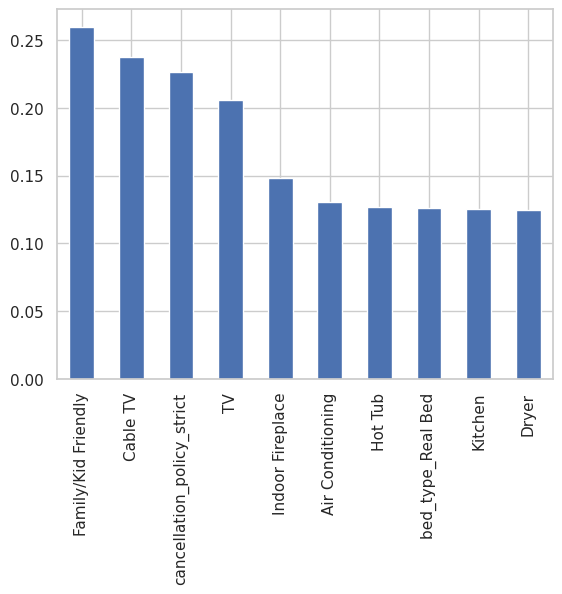

In [ ]:
prop_price_dum_df = room_prop_dummies.join(listing_df['price'])
prop_price_corr = prop_price_dum_df.corr()['price'].sort_values(ascending=False)
prop_price_corr.drop('price', inplace=True)
# Select the top 10 positive correlation features to display
prop_price_corr[prop_price_corr > 0].head(10).plot.bar()

<Axes: >

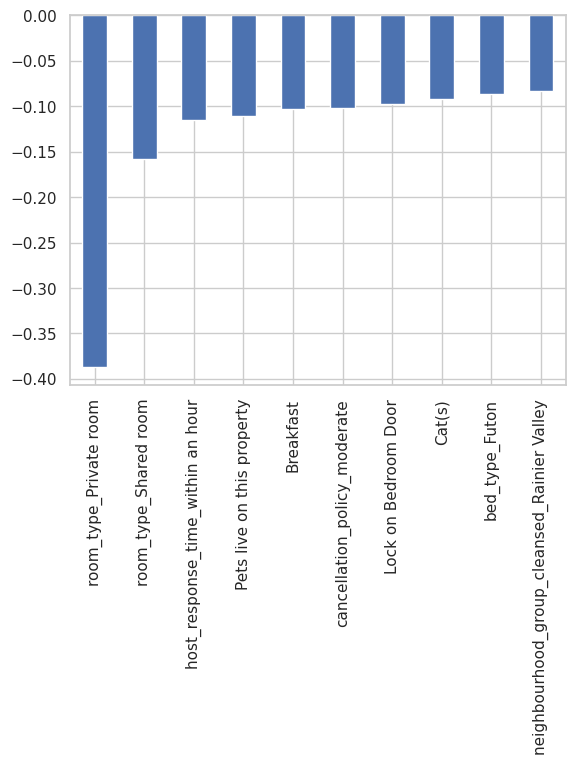

In [ ]:
prop_price_corr[prop_price_corr < 0].tail(10).sort_values().plot.bar()

<Axes: >

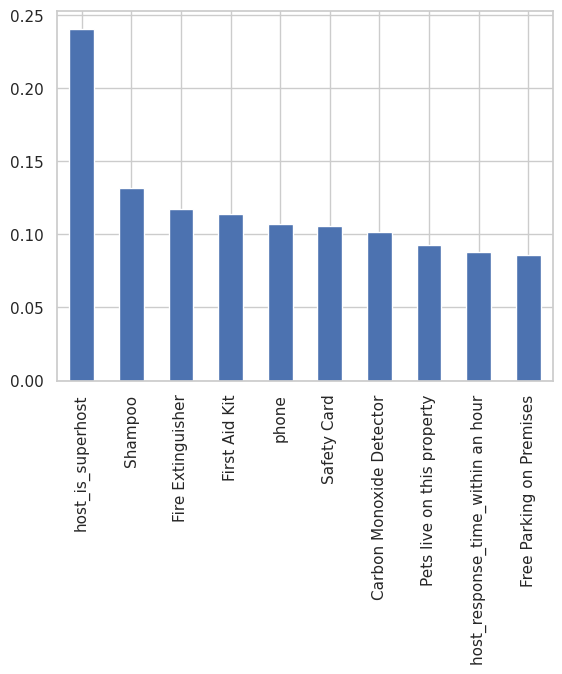

In [ ]:
prop_review_dum_df = room_prop_dummies.join(listing_df['review_scores_rating'])
prop_review_corr = prop_review_dum_df.corr()['review_scores_rating'].sort_values(ascending=False)
prop_review_corr.drop('review_scores_rating', inplace=True)
# Select the top 10 positive correlation features to display
prop_review_corr[prop_review_corr > 0].head(10).plot.bar()

<Axes: >

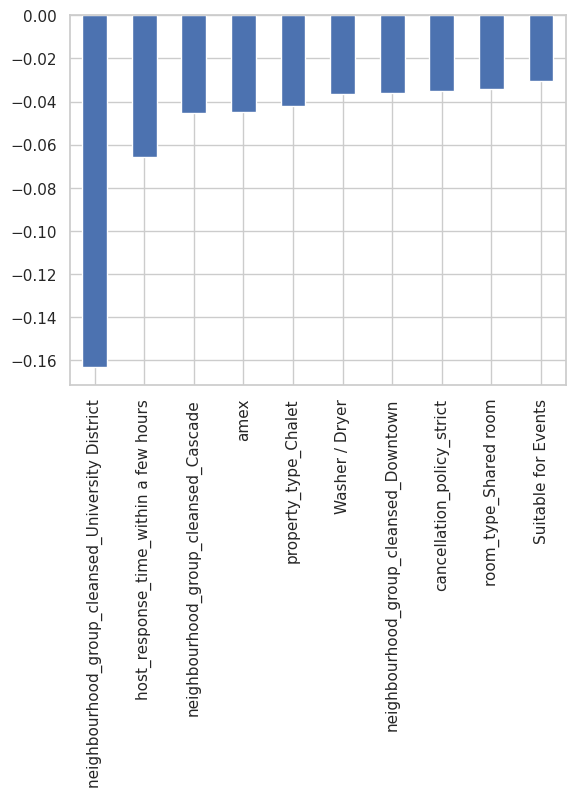

In [ ]:
prop_review_corr[prop_review_corr < 0].tail(10).sort_values().plot.bar()

<Axes: >

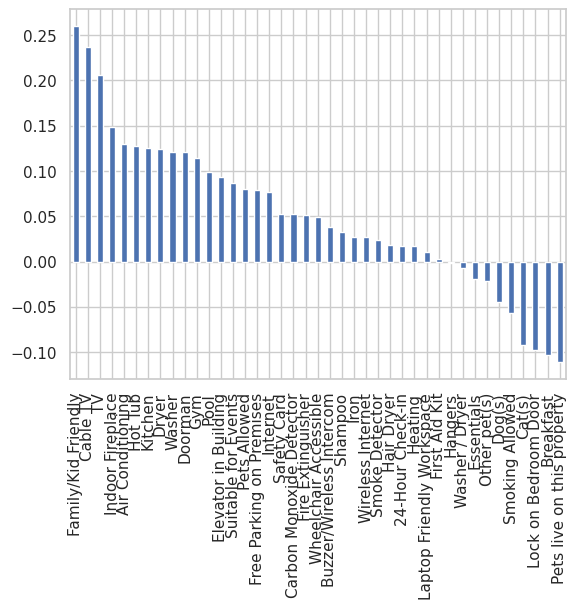

In [ ]:
ame_price_dum_df = ame_dummy.join(listing_df['price'])
ame_price_corr = ame_price_dum_df.corr()['price'].sort_values(ascending=False)
ame_price_corr.drop('price', inplace=True)
ame_price_corr.plot.bar()

<Axes: >

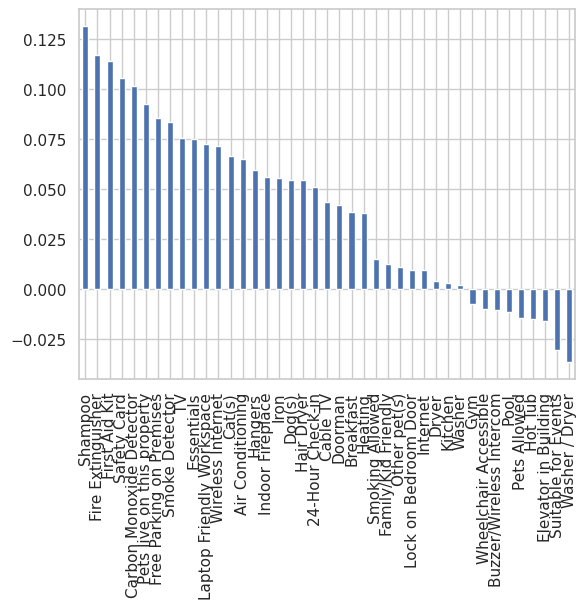

In [ ]:
ame_review_dum_df = ame_dummy.join(listing_df['review_scores_rating'])
ame_review_corr = ame_review_dum_df.corr()['review_scores_rating'].sort_values(ascending=False)
ame_review_corr.drop('review_scores_rating', inplace=True)
ame_review_corr.plot.bar()

array([[<Axes: title={'center': 'id'}>,
        <Axes: title={'center': 'scrape_id'}>,
        <Axes: title={'center': 'host_id'}>,
        <Axes: title={'center': 'host_response_rate'}>,
        <Axes: title={'center': 'host_acceptance_rate'}>,
        <Axes: title={'center': 'host_is_superhost'}>,
        <Axes: title={'center': 'host_listings_count'}>],
       [<Axes: title={'center': 'host_total_listings_count'}>,
        <Axes: title={'center': 'host_has_profile_pic'}>,
        <Axes: title={'center': 'host_identity_verified'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'accommodates'}>,
        <Axes: title={'center': 'bathrooms'}>],
       [<Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'beds'}>,
        <Axes: title={'center': 'square_feet'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'weekly_price'}>,
        <Axes: title={'center': 'monthl

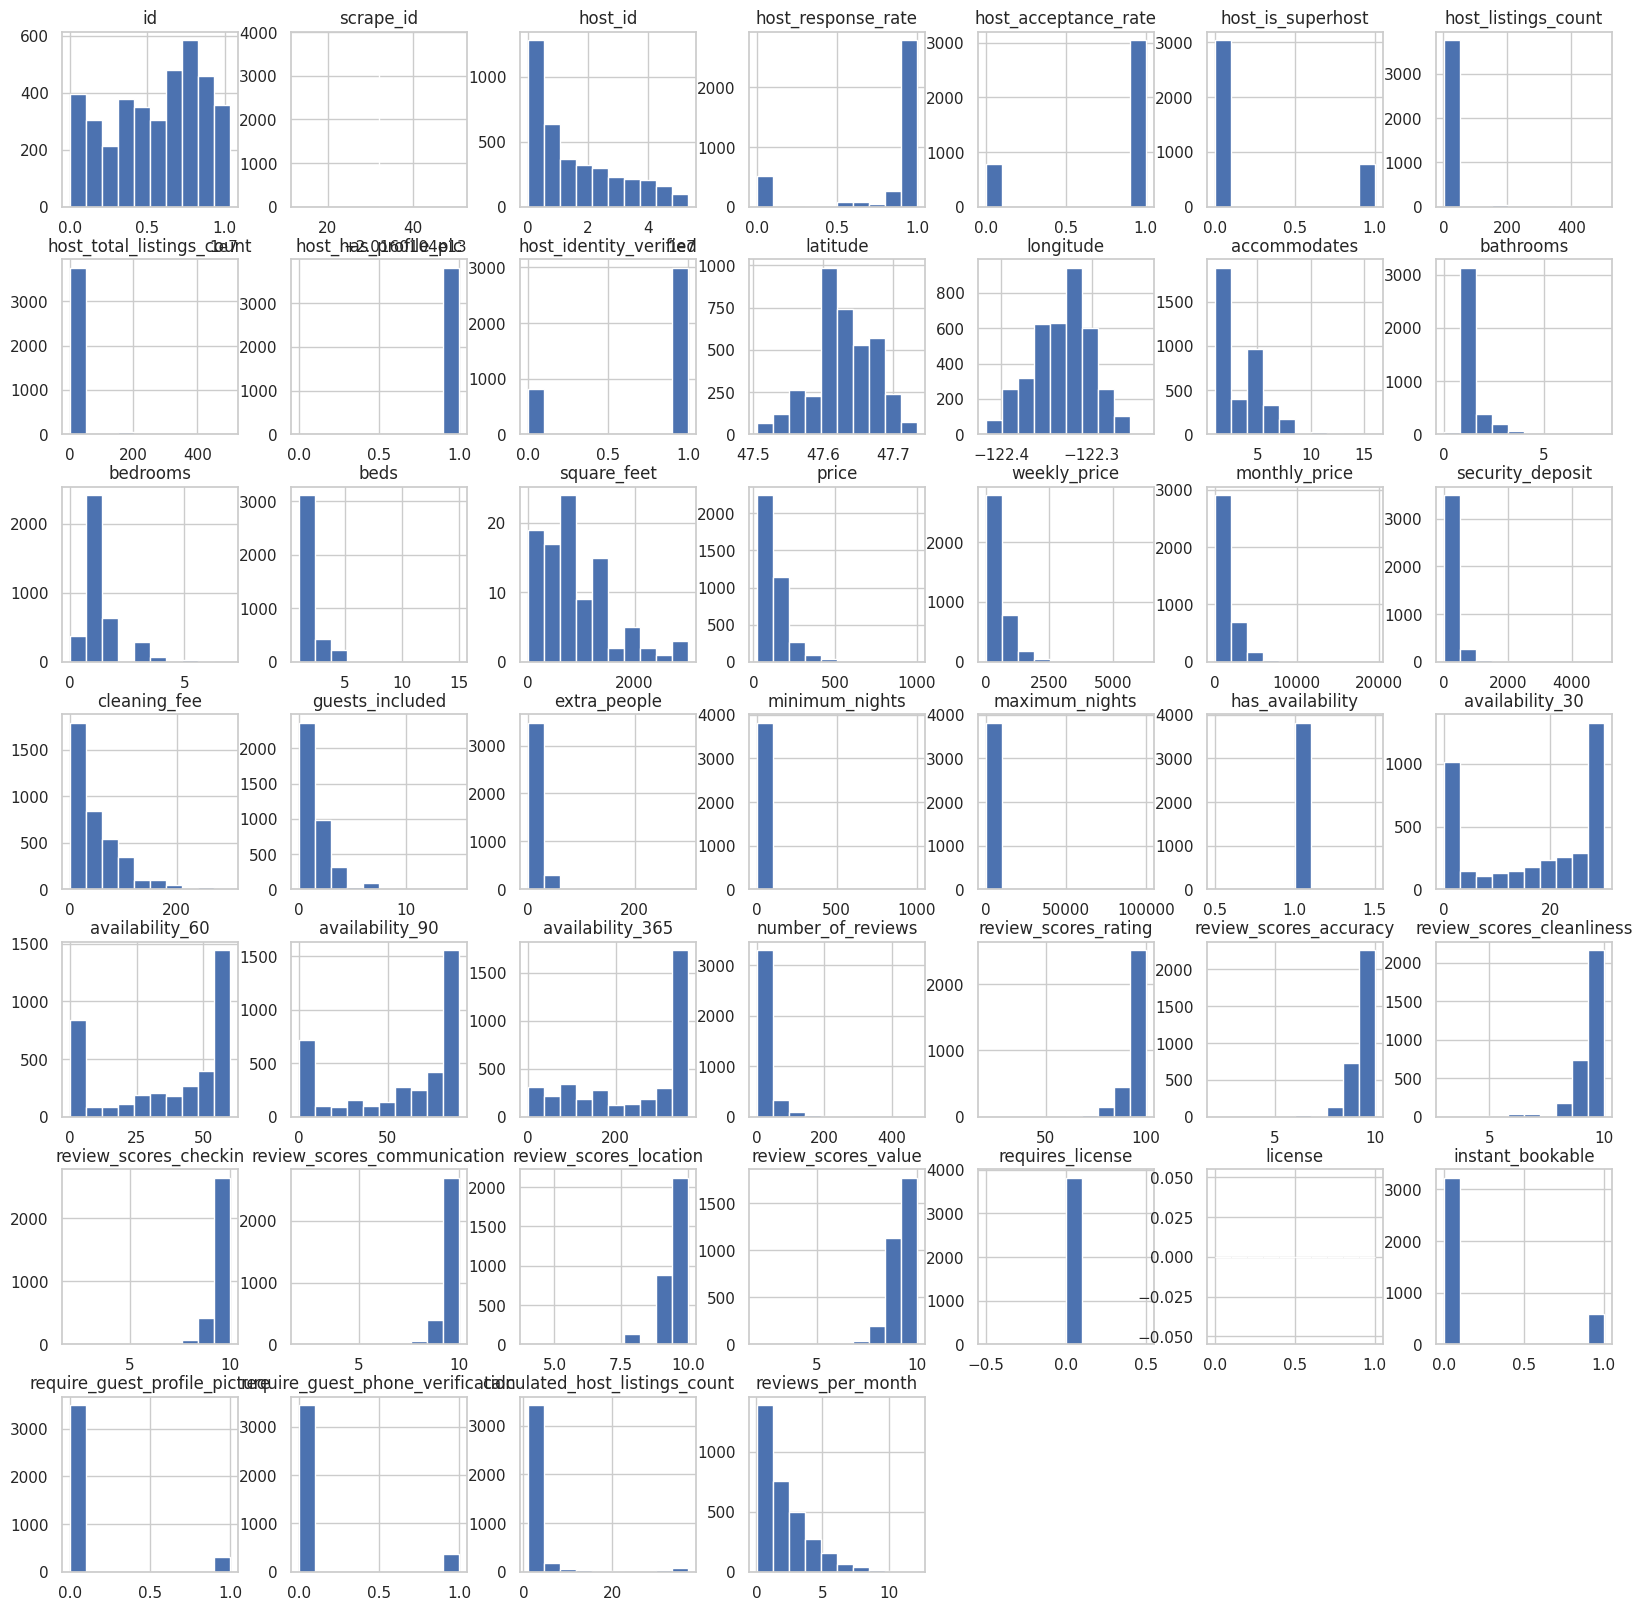

In [ ]:
listing_df.hist(figsize=(20, 20))

<ipython-input-19-6968e33de3a8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(listing_df.corr())


<Axes: >

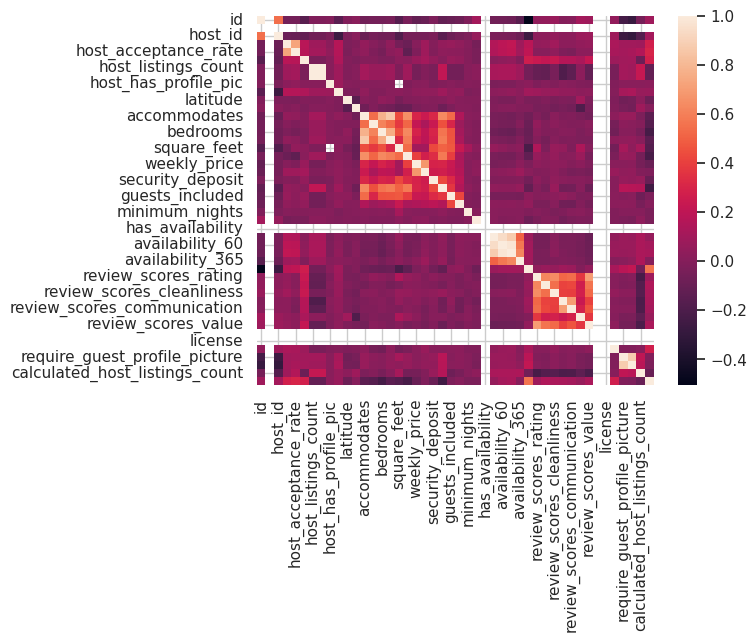

In [ ]:
sns.heatmap(listing_df.corr())

<ipython-input-20-be564108a836>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  listing_df.corr()['price'].sort_values(ascending=False).plot.bar()


<Axes: >

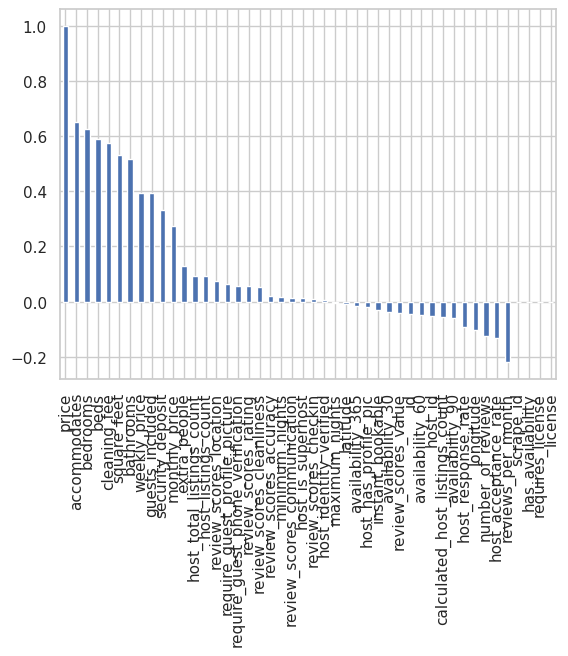

In [ ]:
listing_df.corr()['price'].sort_values(ascending=False).plot.bar()

<ipython-input-21-6f96ecdf5438>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  listing_df.corr()['review_scores_rating'].sort_values(ascending=False).plot.bar()


<Axes: >

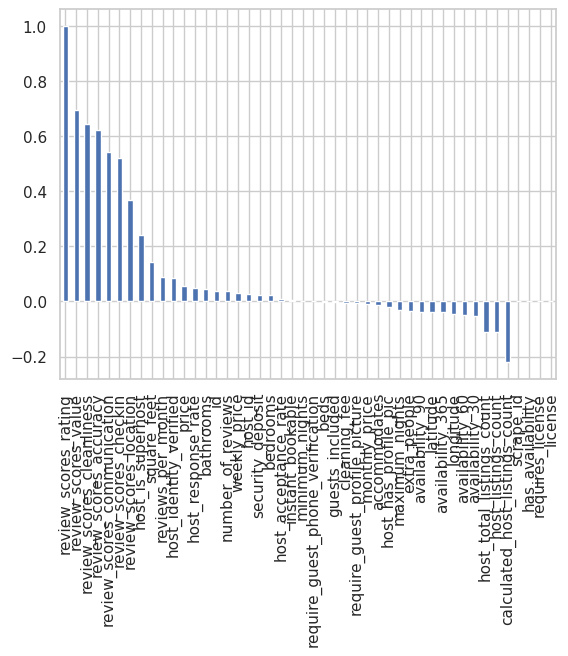

In [ ]:
listing_df.corr()['review_scores_rating'].sort_values(ascending=False).plot.bar()

Text(0.5, 1.0, 'Location and price distribution of all listings')

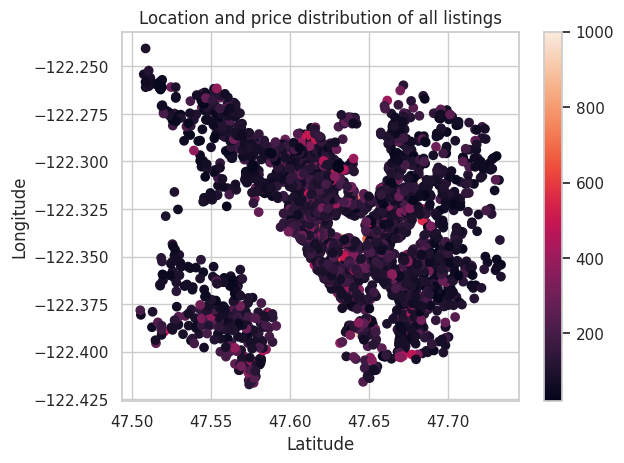

In [ ]:
plt.scatter(listing_df['latitude'], listing_df['longitude'], c=listing_df['price'])
plt.colorbar()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Location and price distribution of all listings')

Text(0, 0.5, '# of listings')

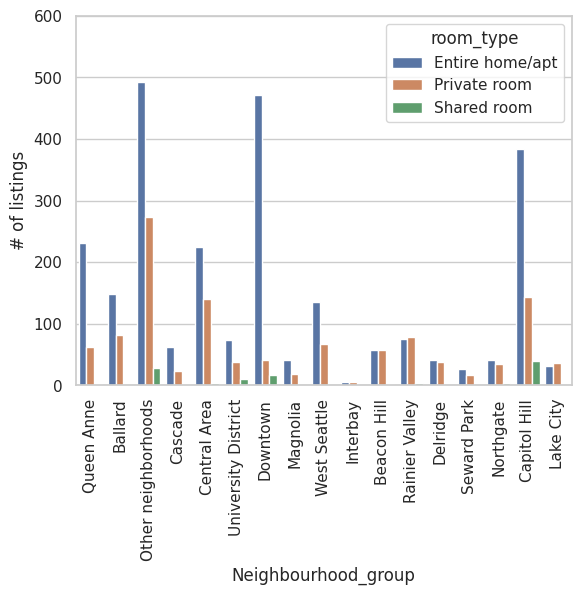

In [ ]:
ax2_5_b_1 = sns.countplot(data=listing_df, x='neighbourhood_group_cleansed', hue='room_type')
ax2_5_b_1.set_xticklabels(ax2_5_b_1.get_xticklabels(), rotation=90)
ax2_5_b_1.set_ylim(0, 600)
ax2_5_b_1.set_xlabel('Neighbourhood_group')
ax2_5_b_1.set_ylabel('# of listings')

(0.0, 500.0)

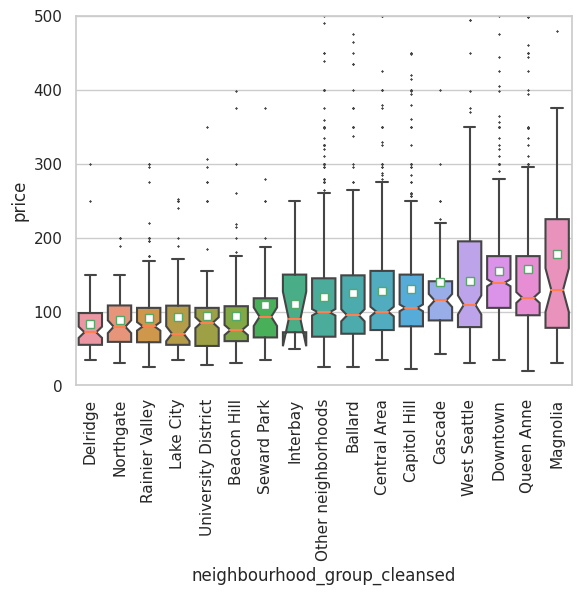

In [ ]:
order = listing_df.groupby(['neighbourhood_group_cleansed'])['price'].mean().sort_values().index.values
sns.boxplot(data=listing_df, x='neighbourhood_group_cleansed', y='price', fliersize=1, showmeans=True,
            flierprops={"marker": "x"}, medianprops={"color": "coral"}, notch=True, order=order,
            meanprops={"marker": "s", "markerfacecolor": "white"})
plt.xticks(rotation=90)
plt.ylim(0, 500)

In [ ]:
print(num_listing_df.columns.values)

# remove the irrelevant and columns without any analytical value
# Irrelevant columns: 'scarpe_id', 'id', 'host_id', 'license', 'host_listings_count','host_total_listings_count',
# 'calculated_host_listings_count'
# Columns without any analytical value:'latitude', 'longitude'
print('THe columns value of num_listing_df:'.format(num_listing_df.columns.values))
y_for_price_df = num_listing_df['price']
num_listing_df.drop(['scrape_id', 'id', 'host_id', 'license', 'host_listings_count', 'host_total_listings_count',
                     'calculated_host_listings_count', 'latitude', 'longitude', 'number_of_reviews',
                     'minimum_nights', 'maximum_nights', 'square_feet', 'weekly_price', 'monthly_price', 'price',
                     'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                     'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                     'review_scores_value', 'extra_people'
                     ], axis=1, inplace=True)
train_df = num_listing_df.join(room_prop_dummies)
train_df.fillna(0, inplace=True)
print("Dummy of room properties has been created!")

['id' 'scrape_id' 'host_id' 'host_response_rate' 'host_acceptance_rate'
 'host_listings_count' 'host_total_listings_count' 'latitude' 'longitude'
 'accommodates' 'bathrooms' 'bedrooms' 'beds' 'square_feet' 'price'
 'weekly_price' 'monthly_price' 'security_deposit' 'cleaning_fee'
 'guests_included' 'extra_people' 'minimum_nights' 'maximum_nights'
 'availability_30' 'availability_60' 'availability_90' 'availability_365'
 'number_of_reviews' 'review_scores_rating' 'review_scores_accuracy'
 'review_scores_cleanliness' 'review_scores_checkin'
 'review_scores_communication' 'review_scores_location'
 'review_scores_value' 'license' 'calculated_host_listings_count'
 'reviews_per_month']
THe columns value of num_listing_df:
Dummy of room properties has been created!


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y_for_price_df, random_state=1)
# For the price prediction, I choose random forest regression and Lasso regression algorithm
# 3_3 Model parameters setting
lr_model = Lasso(random_state=1, fit_intercept=True, selection='random', max_iter=5000)
rfr_model = RandomForestRegressor(random_state=1)
select_lr = SelectFromModel(lr_model, threshold="median")
select_rfr = SelectFromModel(rfr_model, threshold="median")

# 3_4 Building a pipeline and set parameters for both models
para_grid = [{'classifier': [rfr_model], 'preprocessing': [None], 'PolyFeatures': [None],
              'feature_selection': [select_rfr], 'classifier__n_estimators': np.arange(50, 150, 10),
              'classifier__max_depth': [3, 4, 5]},
             {'classifier': [lr_model], 'preprocessing': [StandardScaler()],
              'PolyFeatures': [PolynomialFeatures(degree=2)], 'feature_selection': [select_lr],
              'classifier__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
             ]
pipe = Pipeline([('preprocessing', StandardScaler()), ('feature_selection', select_lr),
                 ('PolyFeatures', PolynomialFeatures(degree=2)), ('classifier', lr_model)])
grid = GridSearchCV(pipe, param_grid=para_grid, cv=5, n_jobs=-1, scoring='r2')
grid.fit(X_train, y_train)

y_pred_train = grid.predict(X_train)  # Predict output on train dataset
y_pred_test = grid.predict(X_test)  # Predict output on test datatset

print("R2 score of train dataset = {:.3f}".format(r2_score(y_train, y_pred_train)))
print("R2 score of test dataset = {:.3f} ".format(r2_score(y_test, y_pred_test)))

print("best_estimator setting:{}".format(grid.best_score_))
print("Best parameters:{}".format(grid.best_params_))
print("Best scorer:{}".format(grid.scorer_))

print("Finish!")

R2 score of train dataset = 0.773
R2 score of test dataset = 0.588 
best_estimator setting:0.5900445460048088
Best parameters:{'PolyFeatures': PolynomialFeatures(), 'classifier': Lasso(alpha=1, max_iter=5000, random_state=1, selection='random'), 'classifier__alpha': 1, 'feature_selection': SelectFromModel(estimator=Lasso(alpha=1, max_iter=5000, random_state=1,
                                selection='random'),
                threshold='median'), 'preprocessing': StandardScaler()}
Best scorer:make_scorer(r2_score)
Finish!


In [ ]:
numeric_part_list = ['security_deposit', 'cleaning_fee', 'guests_included']
plt.clf()
for column in numeric_part_list:
    train_df[column] = np.log(train_df[column] + 1)

# Improvement idea 2: Compartmentalizes the `security_deposit` and `cleanning fee`
security_deposit_df = pd.qcut(train_df['security_deposit'], q=10, duplicates='drop')
cleaning_fee_df = pd.qcut(train_df['cleaning_fee'], q=10, duplicates='drop')
num_listing_df.drop(['security_deposit', 'cleaning_fee'], axis=1, inplace=True)
security_deposit_dum = pd.get_dummies(security_deposit_df, prefix='security_deposit',drop_first=True, dummy_na=True)
cleaning_fee_dum = pd.get_dummies(cleaning_fee_df, prefix='cleaning_fee', drop_first=True, dummy_na=True)
train_df = train_df.join([security_deposit_dum, cleaning_fee_dum])


<Figure size 640x480 with 0 Axes>

Traning Data: r-sqaured score: 0.627
Testing Data: r-sqaured score: 0.583


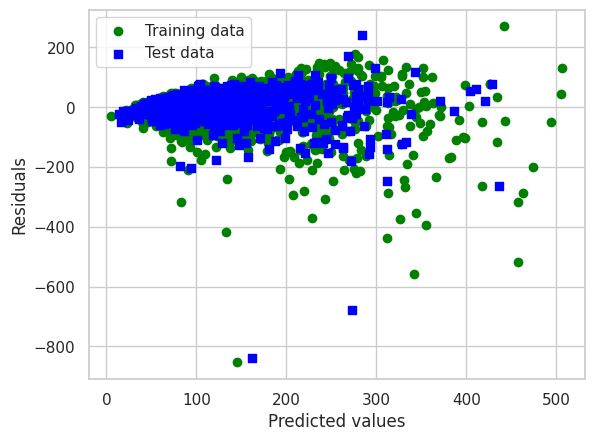

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y_for_price_df, random_state=1)
lasso_model = Lasso(alpha=1, max_iter=15000, fit_intercept=True, selection='random', random_state=1)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
lasso_model.fit(X_train, y_train)
y_test_pred = lasso_model.predict(X_test)
y_train_pred = lasso_model.predict(X_train)

# Print out the result and visualization
print('Traning Data: r-sqaured score: %.3f' % r2_score(y_train, y_train_pred))
print('Testing Data: r-sqaured score: %.3f' % r2_score(y_test, y_test_pred))

plt.scatter(y_train_pred,  y_train_pred - y_train,c='green', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test, c='blue', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')

In [ ]:
print(lasso_model.coef_)
print(train_df.columns)
data = np.array([train_df.columns, lasso_model.coef_]).T
feature_importance_df = pd.DataFrame(data,columns=['Feature name', 'coef'])
# print out the top 20 positive factors of raising the price
print(feature_importance_df.sort_values('coef', ascending=False).head(20))
# print out the top 20 negative factors of lowering the price
print(feature_importance_df.sort_values('coef', ascending=True).head(20))

[-1.12553401e+00 -8.75848742e+00  1.85111919e+01  1.43918607e+01
  2.18286637e+01  8.87925994e-01  0.00000000e+00  0.00000000e+00
  9.24377219e-02  1.32271748e+00  0.00000000e+00  9.42883699e-02
  1.72319809e+00 -3.59147932e+00 -0.00000000e+00  1.47570506e+00
 -0.00000000e+00  5.65178811e-01  0.00000000e+00  0.00000000e+00
 -4.40165413e-01 -0.00000000e+00  4.62052421e+00 -0.00000000e+00
  2.15227780e+00 -1.74738634e-01 -0.00000000e+00 -6.12166123e-01
  0.00000000e+00 -5.79800546e-01  0.00000000e+00 -0.00000000e+00
 -2.76922780e+00 -0.00000000e+00  1.37931613e+00  5.09328933e-01
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -2.12230307e-01
 -2.42840842e-01  9.47570926e-01  0.00000000e+00 -1.00153161e-01
 -1.85583332e+00  1.87147945e+00  0.00000000e+00 -9.22126106e-01
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -1.05691273e+00  0.00000000e+00  0.00000000e+00  4.31192095e-02
  0.00000000e+00 -0.00000

**Analysis on Reviews.csv**

In [ ]:
reviews_df = pd.read_csv(r'reviews.csv', parse_dates=['date'])

# Step 1: general data cleaning
# 1_1: fill Na value with "None" on Comments columns
reviews_df['comments'].fillna("None", inplace=True)
print(reviews_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   listing_id     84849 non-null  int64         
 1   id             84849 non-null  int64         
 2   date           84849 non-null  datetime64[ns]
 3   reviewer_id    84849 non-null  int64         
 4   reviewer_name  84849 non-null  object        
 5   comments       84849 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 3.9+ MB
None


In [ ]:
reviews_df['Year'] = reviews_df['date'].dt.year
reviews_df['Month'] = reviews_df['date'].dt.month
reviews_df['Day'] = reviews_df['date'].dt.day
reviews_df['day_name'] = reviews_df['date'].dt.day_name()

# 1_3 Join the listing_df
listing_join_list = ['id', 'price', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'cleaning_fee',
                     'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                     'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                     'review_scores_value']
review_info_df = pd.DataFrame(reviews_df.groupby('listing_id').count()['comments'].sort_values(ascending=False))
review_info_df = pd.merge(review_info_df, listing_df[listing_join_list], left_index=True, right_on='id')
review_info_df.rename({'comments': 'comment counts'}, axis=1, inplace=True)
print(review_info_df.head(10))

      comment counts      id  price neighbourhood_group_cleansed  \
1447             474  208356   89.0                     Downtown   
1441             466  365550   89.0                     Downtown   
3083             404   25002   75.0                      Ballard   
3600             353   47196   65.0                 Capitol Hill   
2568             320   63308   89.0                 Capitol Hill   
1499             319   92835   99.0                     Downtown   
2166             297    5682   48.0                     Delridge   
2690             294  279063   89.0                 Capitol Hill   
2456             287   53867   86.0          Other neighborhoods   
2668             279  841049   58.0                 Capitol Hill   

     property_type        room_type  cleaning_fee  review_scores_rating  \
1447          Loft     Private room           0.0                  95.0   
1441          Loft     Private room           0.0                  94.0   
3083         House  Entire

In [ ]:
print("There are {} reviewers leave their comments.".format(reviews_df['reviewer_id'].unique().shape[0]))
# 2_1_b: How many listings were commented?
print("There are {} listings were commented.".format(reviews_df['listing_id'].unique().shape[0]))
# 2_1_c: The TOP 10 commented listings
print("TOP 10 commented listing:\n")
print(review_info_df['comment counts'].head(10))

There are 75730 reviewers leave their comments.
There are 3191 listings were commented.
TOP 10 commented listing:

1447    474
1441    466
3083    404
3600    353
2568    320
1499    319
2166    297
2690    294
2456    287
2668    279
Name: comment counts, dtype: int64


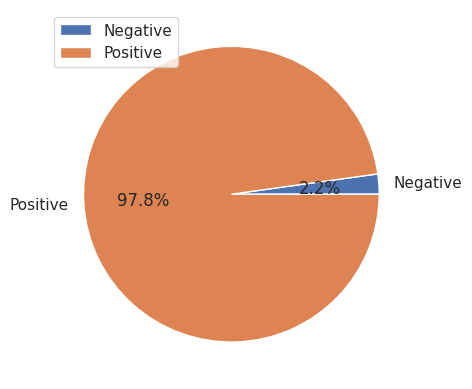

In [ ]:
neg_rating = review_info_df['review_scores_rating'][review_info_df['review_scores_rating'] < 80]
plt.pie([neg_rating.count(), review_info_df.shape[0] - neg_rating.count()], labels=['Negative', 'Positive'],
        autopct='%1.1f%%')
plt.legend()

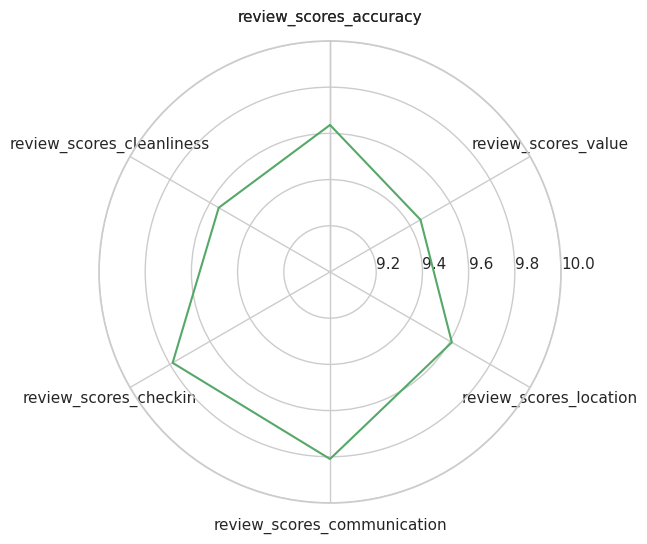

In [ ]:
detail_score_rating_l = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                         'review_scores_communication', 'review_scores_location', 'review_scores_value']
mean_score = review_info_df[detail_score_rating_l].mean(axis=0, skipna=True)

data_length = mean_score.shape[0]
angles = np.linspace(0, 2*np.pi, data_length, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))
labels = np.concatenate((mean_score.index.values, [mean_score.index.values[0]]))
scores = np.concatenate((mean_score.values, [mean_score.values[0]]))
fig = plt.figure(figsize=(8, 6), dpi=100)
ax_2_2_a_2 = plt.subplot(111, polar=True)
ax_2_2_a_2.plot(angles, scores, color='g')
ax_2_2_a_2.set_thetagrids(angles*180/np.pi, labels)
ax_2_2_a_2.set_theta_zero_location('N')
ax_2_2_a_2.set_rlim(9, 10)  # set the r limit from 9 to 10
ax_2_2_a_2.set_rlabel_position(270)

pos_keyword_matrix:
<84220x200 sparse matrix of type '<class 'numpy.int64'>'
	with 1304947 stored elements in Compressed Sparse Row format>


(-0.5, 1599.5, 799.5, -0.5)

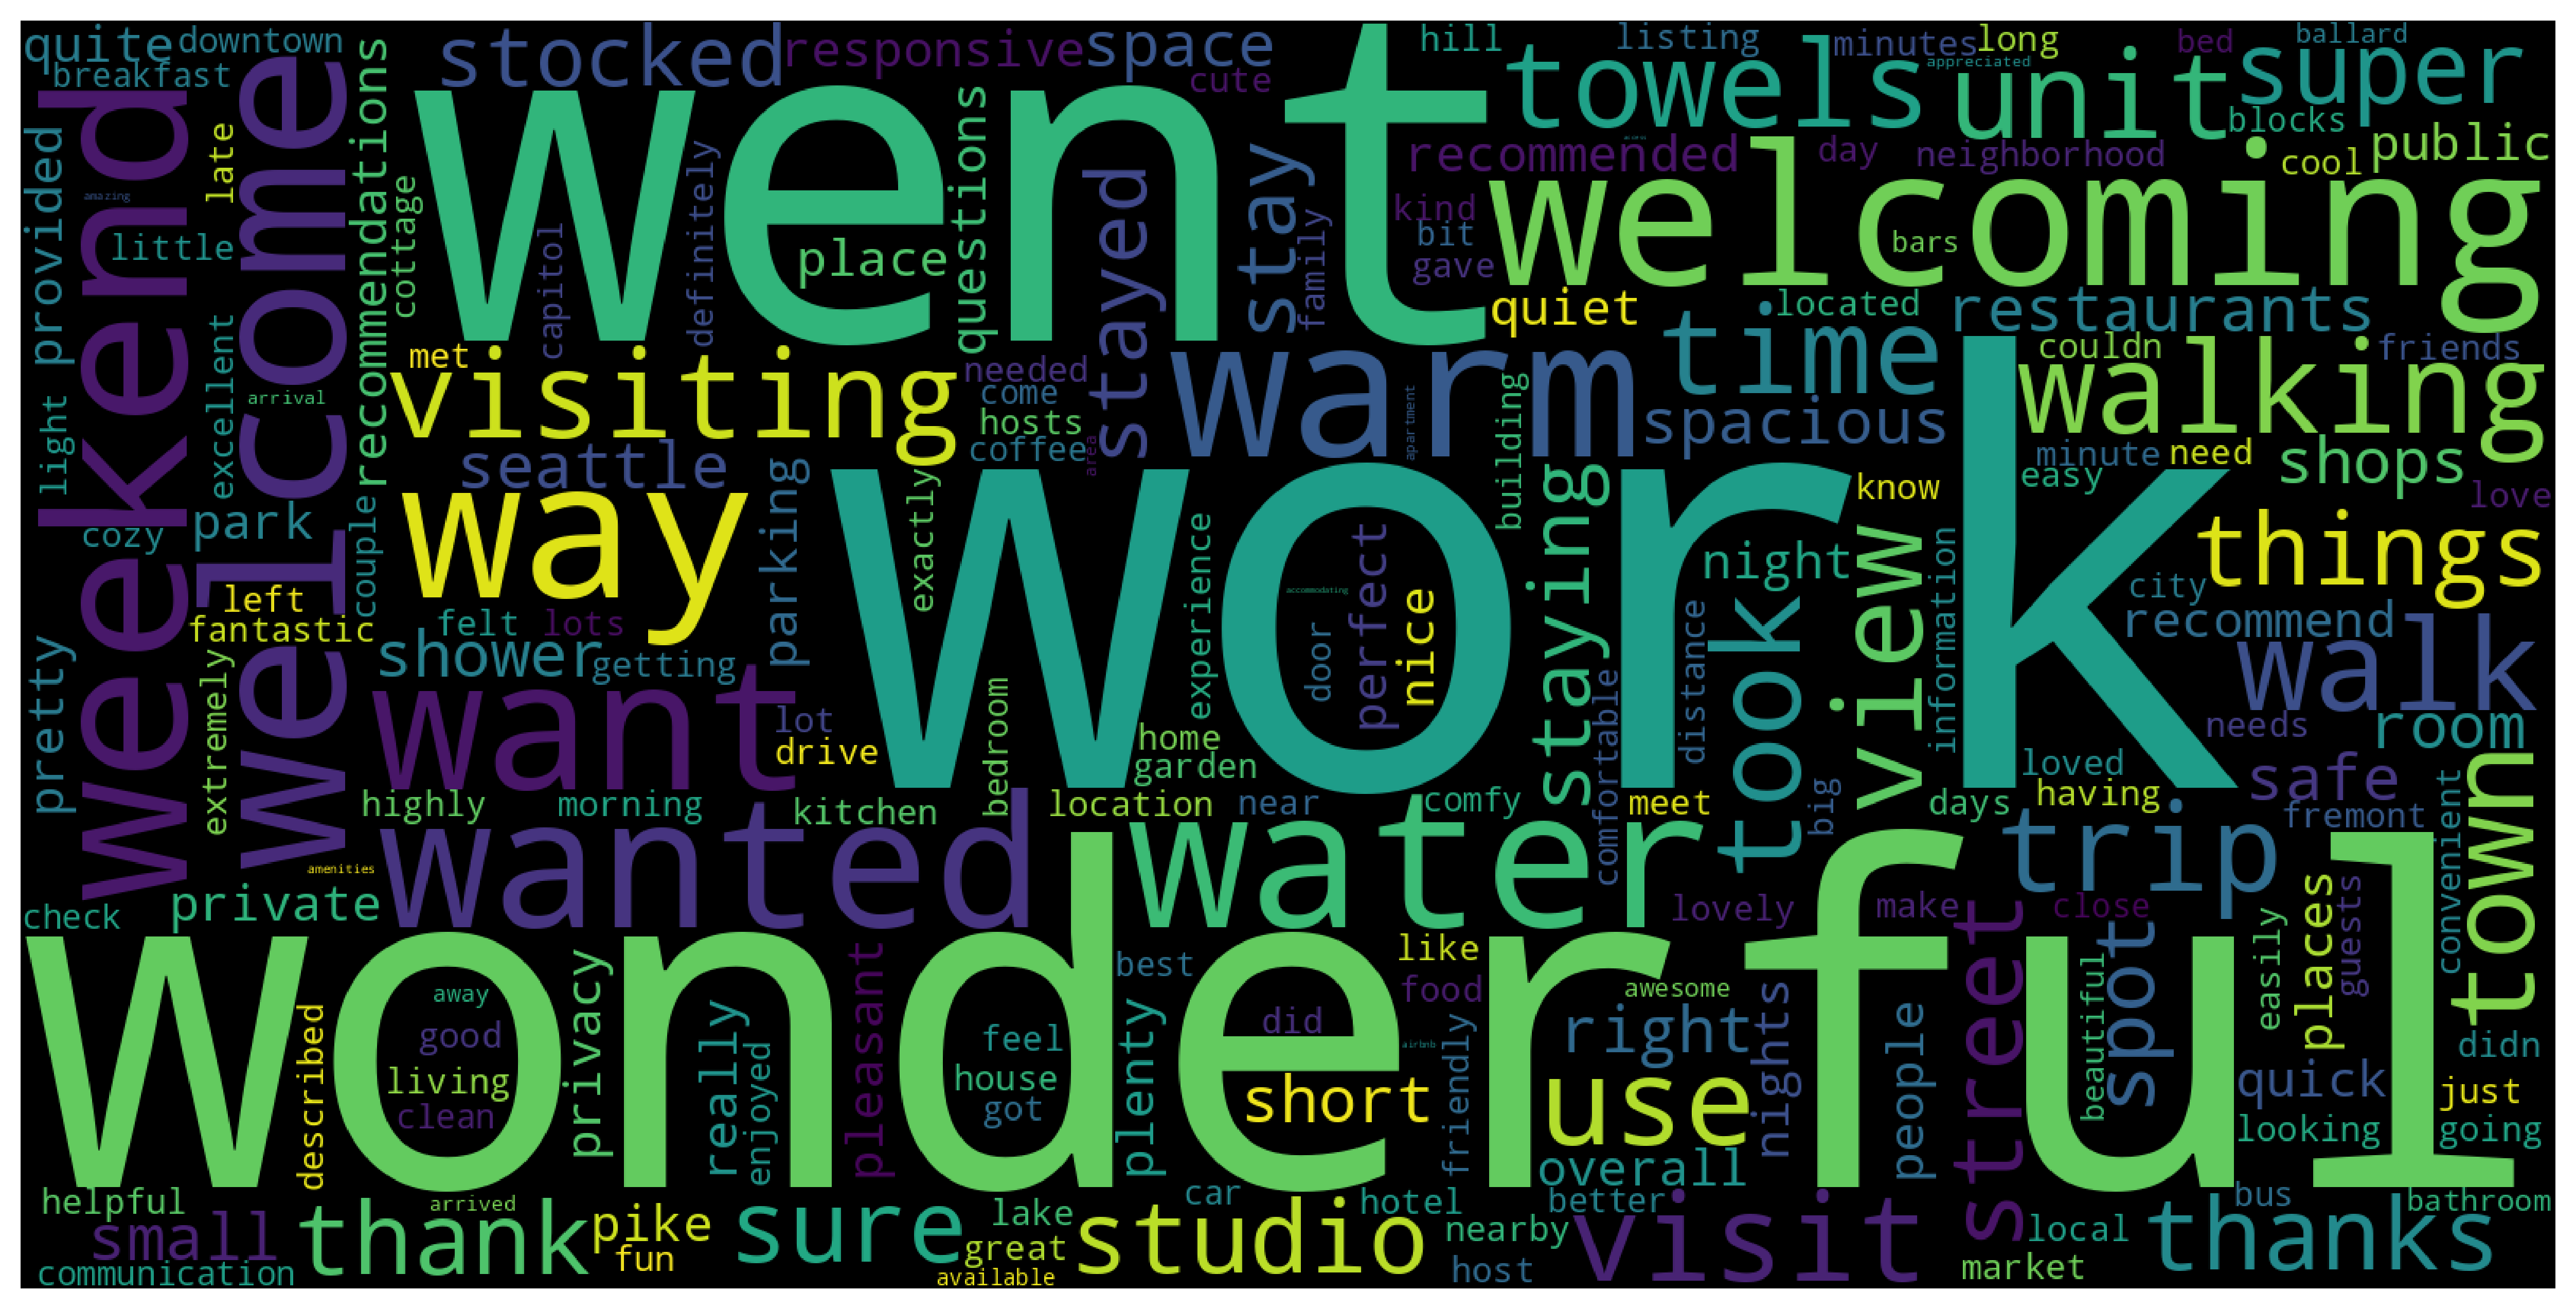

In [ ]:
pos_listing_id = review_info_df[review_info_df['review_scores_rating'] >= 80]['id'].values
pos_review_kw_df = reviews_df.loc[reviews_df['listing_id'].isin(pos_listing_id), 'comments']
# print(pos_review_kw_df)
pos_keyword_vect = CountVectorizer(stop_words='english', min_df=5, max_features=200, decode_error='ignore').\
    fit(pos_review_kw_df)
pos_keyword_ma = pos_keyword_vect.transform(pos_review_kw_df)
print("pos_keyword_matrix:\n{}".format(repr(pos_keyword_ma)))
pos_keyword_dict = pos_keyword_vect.vocabulary_
pos_word_wc = wc.WordCloud(width=1600, height=800)
pos_word_wc.generate_from_frequencies(pos_keyword_dict)
plt.figure(figsize=(20, 8), dpi=400)
plt.tight_layout(pad=0)
plt.imshow(pos_word_wc)  # Showing the wordcloud
plt.axis('off')  # Turn off the axis

neg_keyword_matrix:
<609x200 sparse matrix of type '<class 'numpy.int64'>'
	with 9521 stored elements in Compressed Sparse Row format>


(-0.5, 1599.5, 799.5, -0.5)

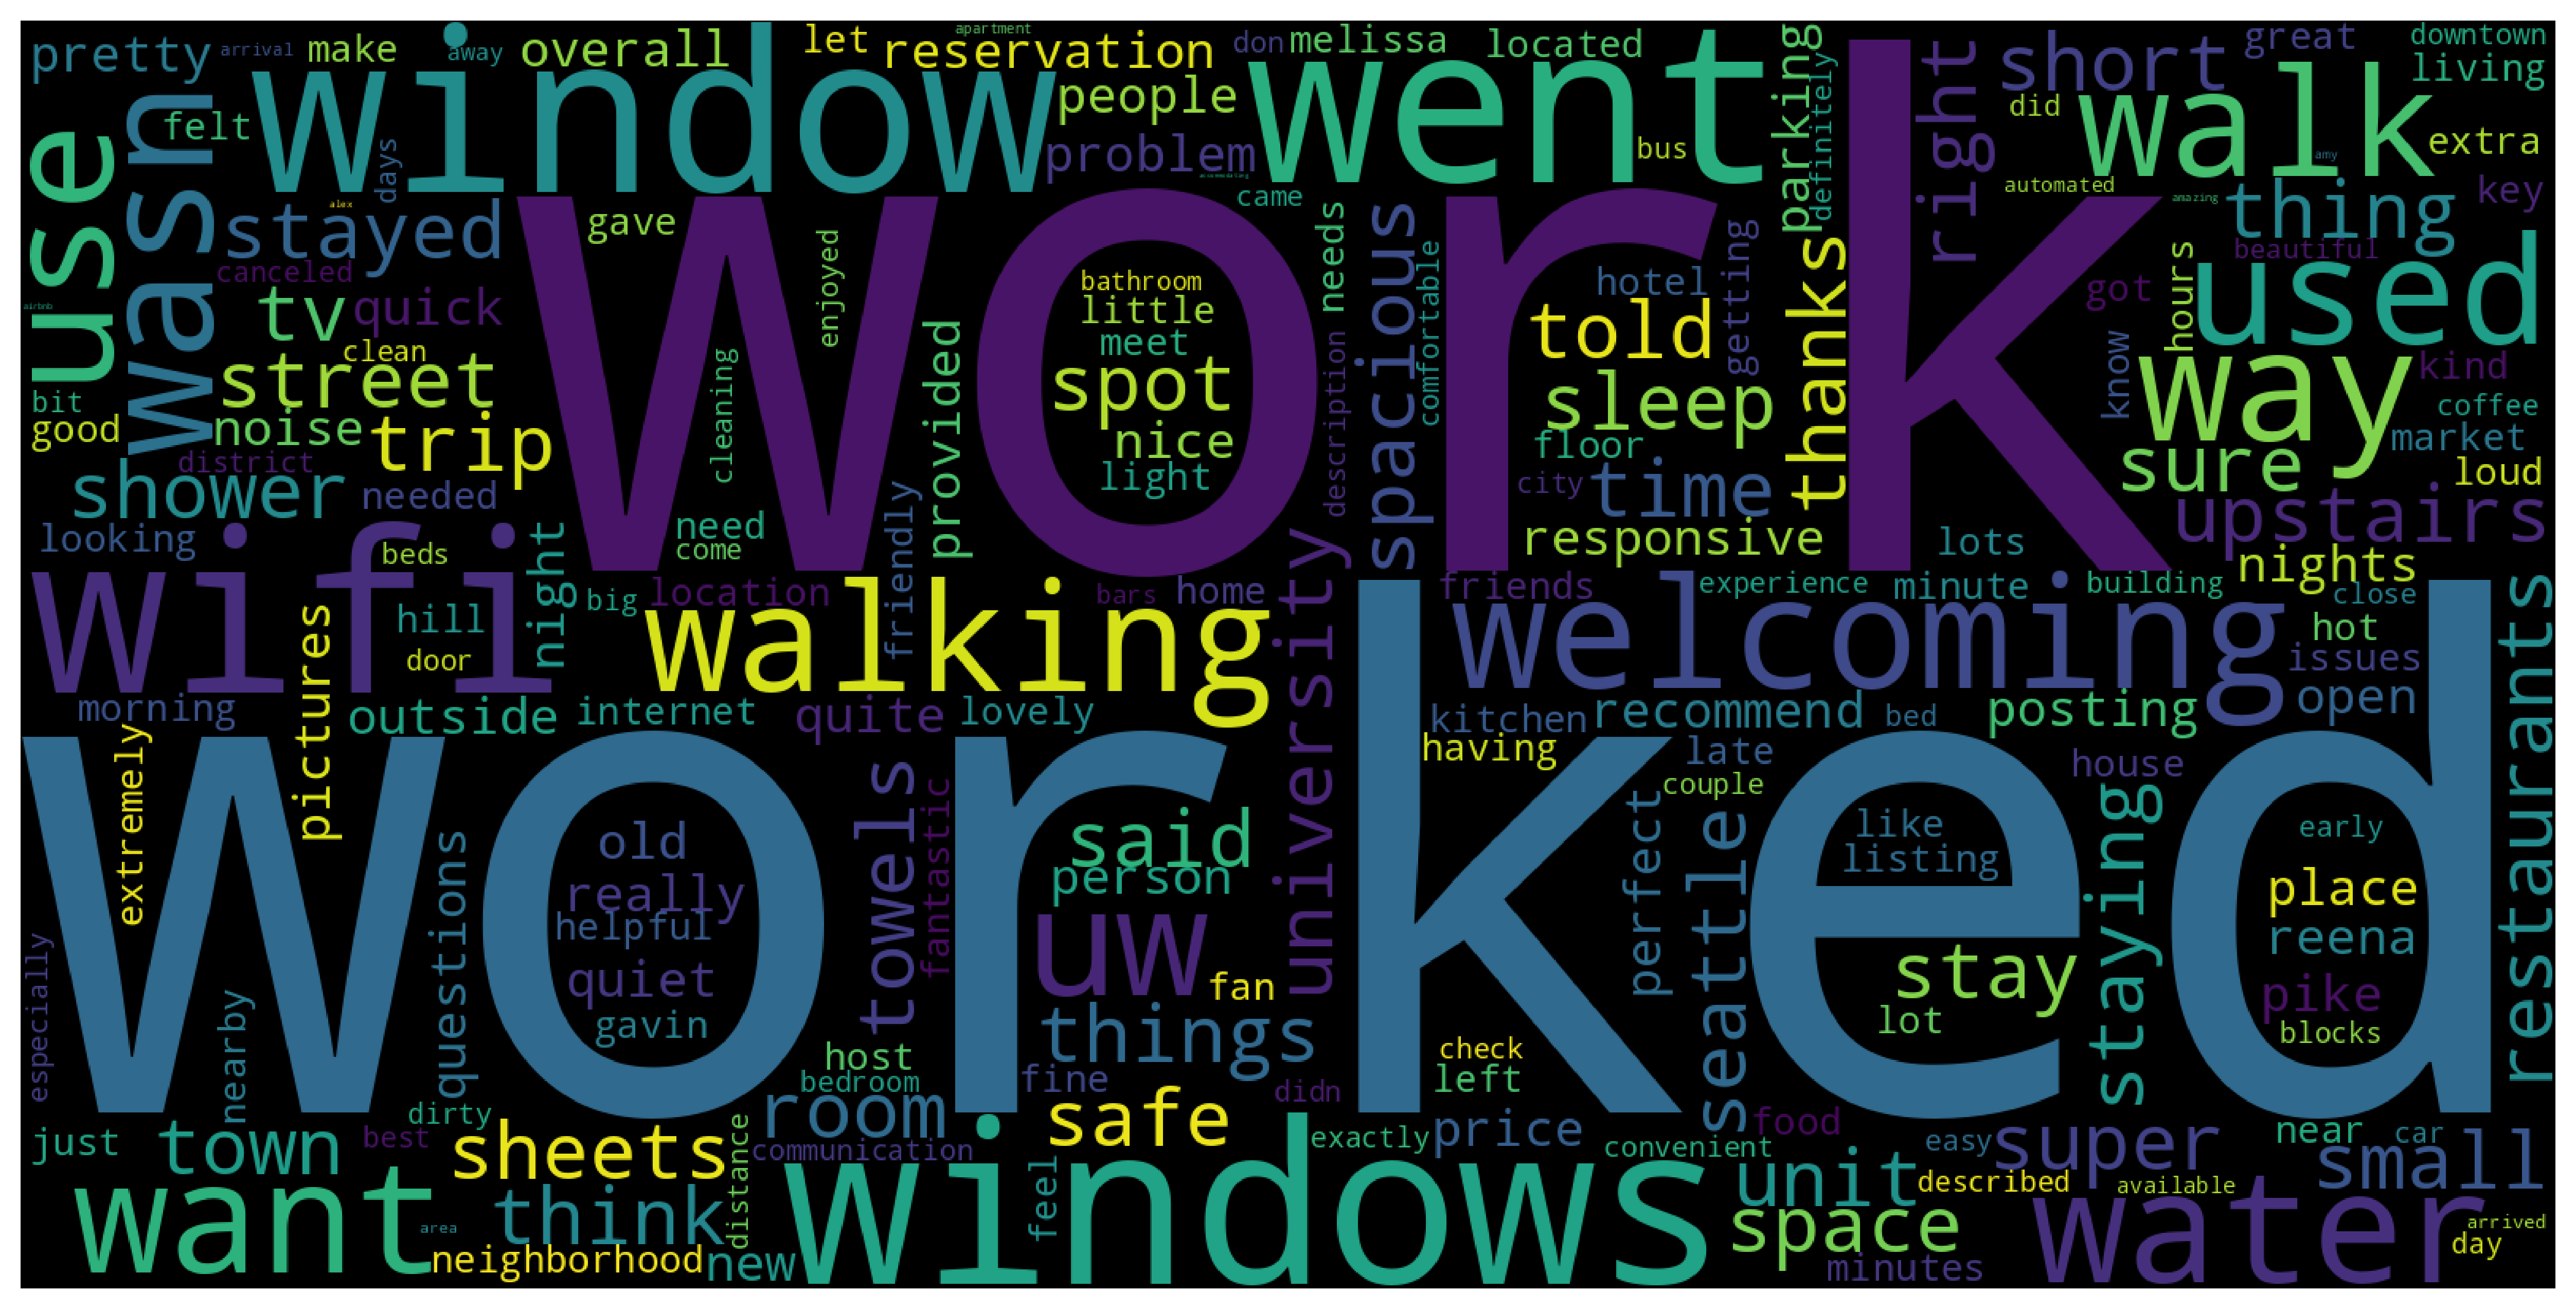

In [ ]:
neg_listing_id = review_info_df[review_info_df['review_scores_rating'] < 80]['id']
neg_review_kw_df = reviews_df.loc[reviews_df['listing_id'].isin(neg_listing_id), 'comments']
# print(neg_review_kw_df)
neg_keyword_vect = CountVectorizer(stop_words='english', min_df=5, max_features=200, decode_error='ignore').\
    fit(neg_review_kw_df)
neg_keyword_ma = neg_keyword_vect.transform(neg_review_kw_df)
print("neg_keyword_matrix:\n{}".format(repr(neg_keyword_ma)))
neg_keyword_dict = neg_keyword_vect.vocabulary_
neg_word_wc = wc.WordCloud(width=1600, height=800)
neg_word_wc.generate_from_frequencies(neg_keyword_dict)
plt.figure(figsize=(20, 8), dpi=400)
plt.tight_layout(pad=0)
plt.imshow(neg_word_wc)  # display the wordcloud
plt.axis('off')